## Transfer Learning

<a href="https://colab.research.google.com/github/jgamero-ibrobotics/trabajo-pic/blob/Jesus/TransferLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [48]:
import numpy as np
import thop
import copy
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader
from torchsummary import summary
from torch.utils.data import sampler
import torchvision.datasets as datasets
import torchvision.transforms as T
from torchvision import models

In [3]:
import matplotlib.pyplot as plt

### Descargar sets de datos

In [4]:
DATA_PATH = '/media/josh/MyData2SSD/Databases/cifar-10-batches-py'
NUM_TRAIN = 45000
MINIBATCH_SIZE = 64
transform_imagenet = T.Compose([
                T.Resize(224),
                T.ToTensor(),
                T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
            ])

transform_cifar = T.Compose([
                T.ToTensor(),
                T.Normalize([0.491, 0.482, 0.447], [0.247, 0.243, 0.261])
            ])

# Training set loader
cifar10_train = datasets.CIFAR10(DATA_PATH, train=True, download=True,
                             transform=transform_imagenet)
train_loader = DataLoader(cifar10_train, batch_size=MINIBATCH_SIZE, 
                          sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

# Validation set loader
cifar10_val = datasets.CIFAR10(DATA_PATH, train=True, download=True,
                           transform=transform_imagenet)
val_loader = DataLoader(cifar10_val, batch_size=MINIBATCH_SIZE, 
                        sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN, len(cifar10_val))))

# Testing set loader
cifar10_test = datasets.CIFAR10(DATA_PATH, train=False, download=True, 
                            transform=transform_imagenet)
test_loader = DataLoader(cifar10_test, batch_size=MINIBATCH_SIZE)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [ ]:
for i, (x, y) in enumerate(val_loader):
    print(i, x.shape, y.shape)

### Usar GPU

In [5]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print(device)

cpu


### Mostrar imágenes

La imagen muestreada representa un: Truck


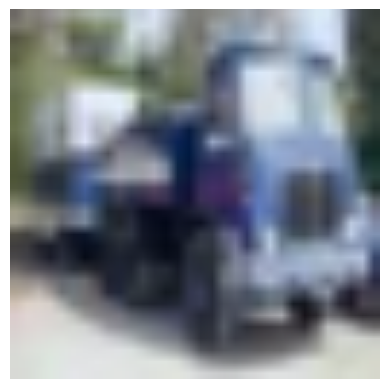

In [6]:
classes = ['Plane', 'Car', 'Bird', 'Cat', 'Deer','Dog', 'Frog', 'Horse', 'Ship', 'Truck']

def plot_figure(image):
    plt.imshow(image.permute(1,2,0))
    plt.axis('off')
    plt.show()

rnd_sample_idx = np.random.randint(len(test_loader))
print(f'La imagen muestreada representa un: {classes[test_loader.dataset[rnd_sample_idx][1]]}')
image = test_loader.dataset[rnd_sample_idx][0]
image = (image - image.min()) / (image.max() -image.min() )
plot_figure(image)

### Calcular Accuracy y Perdida

In [55]:
def test(model, loader): # funcion para calcular la precision del modelo
    num_correct = 0
    num_total = 0
    epoch_loss = 0.0
    model.eval() # ponemos el modelo en modo evaluacion
    model = model.to(device=device) # movemos el modelo al device (cpu o gpu)
    with torch.no_grad(): # deshabilitamos el calculo del gradiente (no necesita actualizar pesos)

        # xi: datos de entrada, yi: etiquetas
        for (xi, yi) in loader: # iteramos sobre los minibatches del loader de validacion o test 
            xi = xi.to(device=device, dtype = torch.float32) # movemos los datos al device (cpu o gpu) 
            yi = yi.to(device=device, dtype = torch.long) # movemos los datos al device (cpu o gpu)
            scores = model(xi) # mb_size, 10. corre el modelo sobre los datos de entrada
            loss =  F.cross_entropy(input=scores, target=yi)

            epoch_loss += loss.item()
            _, pred = scores.max(dim=1) #pred shape (mb_size). obtenemos la clase con mayor score (prediccion)   
            # comparamos las predicciones con las etiquetas y sumamos el numero de predicciones correctas
            num_correct += (pred == yi).sum() # pred shape (mb_size), yi shape (mb_size, 1).
            # sumamos 1 por cada prediccion correcta
            num_total += pred.size(0)


        loss_ = epoch_loss / len(loader)
        accuracy = float(num_correct)/num_total   

        return loss_, accuracy

### Cargar modelo pre-entrenado

In [8]:
model_resnet18 = models.resnet18(pretrained=True)
# model_resnet18 = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)

C:\Users\jesus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\jesus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


#### Exploremos el modelo

In [9]:
for i, w in enumerate(model_resnet18.parameters()):
    print(i, w.shape, w.requires_grad)

0 torch.Size([64, 3, 7, 7]) True
1 torch.Size([64]) True
2 torch.Size([64]) True
3 torch.Size([64, 64, 3, 3]) True
4 torch.Size([64]) True
5 torch.Size([64]) True
6 torch.Size([64, 64, 3, 3]) True
7 torch.Size([64]) True
8 torch.Size([64]) True
9 torch.Size([64, 64, 3, 3]) True
10 torch.Size([64]) True
11 torch.Size([64]) True
12 torch.Size([64, 64, 3, 3]) True
13 torch.Size([64]) True
14 torch.Size([64]) True
15 torch.Size([128, 64, 3, 3]) True
16 torch.Size([128]) True
17 torch.Size([128]) True
18 torch.Size([128, 128, 3, 3]) True
19 torch.Size([128]) True
20 torch.Size([128]) True
21 torch.Size([128, 64, 1, 1]) True
22 torch.Size([128]) True
23 torch.Size([128]) True
24 torch.Size([128, 128, 3, 3]) True
25 torch.Size([128]) True
26 torch.Size([128]) True
27 torch.Size([128, 128, 3, 3]) True
28 torch.Size([128]) True
29 torch.Size([128]) True
30 torch.Size([256, 128, 3, 3]) True
31 torch.Size([256]) True
32 torch.Size([256]) True
33 torch.Size([256, 256, 3, 3]) True
34 torch.Size([25

In [ ]:
model_resnet18

#### Ajustar a nuestro modelo

In [10]:
model_aux = nn.Sequential(*list(model_resnet18.children()))
model_aux

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [11]:
model_aux = nn.Sequential(*list(model_resnet18.children())[:-1])

In [ ]:
model_aux

In [12]:
for i, parameter in enumerate(model_aux.parameters()):
    parameter.requires_grad = False

In [ ]:
for i, parameter in enumerate(model_aux.parameters()):
    print(i, parameter.requires_grad)

### Loop de entrenamiento

In [13]:
def train(model, optimizer, loader, lr_scheduler):
    
    for (xi, yi) in loader:
        model.train()
        xi = xi.to(device=device, dtype=torch.float32) 
        yi = yi.to(device=device, dtype=torch.long)
        scores = model(xi)
        loss = F.cross_entropy(input= scores, target=yi)
    
        optimizer.zero_grad()           
        loss.backward()
        optimizer.step()
    lr_scheduler.step()

In [14]:
lr = 0.0015
epochs = 10
model1 = nn.Sequential(model_aux,
                       nn.Flatten(), 
                       nn.Linear(in_features=512, out_features= 10, bias= True))
optimizer = torch.optim.Adam(model1.parameters(), lr=lr, betas=(0.9, 0.999))
lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.85)

In [ ]:
model1 = model1.to(device=device)
summary(model1, (3, 224, 224))
flops, params = thop.profile(model1, verbose=False,
                             inputs=(torch.randn(1, 3, 224, 224).to(device),))
(flops, params) = thop.clever_format([flops, params])
print(f'FLOPs: {flops}, params: {params}')

In [ ]:
model1 = model1.to(device=device)
best_acc = 0.0
train_loss_history = []
val_loss_history = []
train_acc_history = []
val_acc_history = []
lr_history = []

for epoch in range(epochs):

    train(model1, optimizer, train_loader, lr_scheduler)
    epoc_val_loss, epoc_val_accuracy = test(model1, val_loader)
    epoc_train_loss, epoc_train_accuracy = test(model1, train_loader)

    if best_acc <= epoc_train_accuracy:
        best_acc = epoc_train_accuracy
        best_model = copy.deepcopy(model1)

    train_loss_history.append(epoc_train_loss)
    train_acc_history.append(epoc_train_accuracy)   
    val_loss_history.append(epoc_val_loss)
    val_acc_history.append(epoc_val_accuracy) 
    lr_history.append(lr_scheduler.get_last_lr()[0])

    print(f'Epoch: {epoch} ACCURACY (validation): {epoc_val_accuracy:.4f}, ACCURACY (train): {epoc_train_accuracy:.4f},\
           LOSS (validation): {epoc_val_loss:.4f}, LOSS (train): {epoc_train_loss:.4f}')

In [ ]:
# Gráfica de la evolución de la pérdida y la precisión
plt.subplot(3, 1, 1)
plt.plot(train_loss_history, label='train')
plt.plot(val_loss_history, label='test')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(train_acc_history, label='train')
plt.plot(val_acc_history, label='test')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

plt.subplot(3, 1, 3)
plt.plot(lr_history)
plt.xlabel('Epoch')
plt.ylabel('Learning rate')
plt.tight_layout()
plt.show()

In [ ]:
for i, parameter in enumerate(best_model.parameters()):
    parameter.requires_grad = True

In [ ]:
best_model = best_model.to(device=device)
summary(best_model, (3, 224, 224))
flops, params = thop.profile(best_model, verbose=False,
                             inputs=(torch.randn(1, 3, 224, 224).to(device),))
(flops, params) = thop.clever_format([flops, params])
print(f'FLOPs: {flops}, params: {params}')

In [ ]:
best_model = best_model.to(device=device)
best_acc = 0.0
train_loss_history = []
val_loss_history = []
train_acc_history = []
val_acc_history = []
lr_history = []

for epoch in range(epochs):

    train(best_model, optimizer, train_loader, lr_scheduler)
    epoc_val_loss, epoc_val_accuracy = test(best_model, val_loader)
    epoc_train_loss, epoc_train_accuracy = test(best_model, train_loader)

    if best_acc <= epoc_val_accuracy:
        best_acc = epoc_val_accuracy
        best_model_2 = copy.deepcopy(best_model)

    train_loss_history.append(epoc_train_loss)
    train_acc_history.append(epoc_train_accuracy)   
    val_loss_history.append(epoc_val_loss)
    val_acc_history.append(epoc_val_accuracy) 
    lr_history.append(lr_scheduler.get_last_lr()[0])

    print(f'Epoch: {epoch} ACCURACY (validation): {epoc_val_accuracy:.4f}, ACCURACY (train): {epoc_train_accuracy:.4f},\
           LOSS (validation): {epoc_val_loss:.4f}, LOSS (train): {epoc_train_loss:.4f}')

In [ ]:
test_loss, test_acc = test(best_model, test_loader)
print(f'ACCURACY (test): {test_acc:.4f}, LOSS (test): {test_loss:.4f}')

La imagen muestreada representa un: Horse
La clase predicha es: Frog


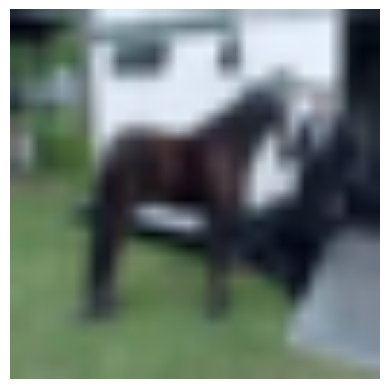

In [58]:
rnd_sample_idx = np.random.randint(len(test_loader))
print(f'La imagen muestreada representa un: {classes[test_loader.dataset[rnd_sample_idx][1]]}')
image = test_loader.dataset[rnd_sample_idx][0]
image = (image - image.min()) / (image.max() -image.min() )

image_t = image.unsqueeze(0)  # Agregar dimensión de tamaño de lote

# Mueve el tensor de entrada al mismo dispositivo que el modelo
image_t = image_t.to(device)
scores = model1(image_t)
_, pred = scores.max(dim=1)
print(f'La clase predicha es: {classes[pred]}')
plot_figure(image)